In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

class Discriminator(nn.Module):
    def __init__(self, n_h):
        super(Discriminator, self).__init__()
        self.f_k = nn.Bilinear(n_h, n_h, 1)

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Bilinear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, c, h_pl, h_mi, s_bias1=None, s_bias2=None):
        c_x = c.expand_as(h_pl)  

        sc_1 = self.f_k(h_pl, c_x)
        sc_2 = self.f_k(h_mi, c_x)

        if s_bias1 is not None:
            sc_1 += s_bias1
        if s_bias2 is not None:
            sc_2 += s_bias2

        logits = torch.cat((sc_1, sc_2), 1)

        return logits
    
class AvgReadout(nn.Module):
    def __init__(self):
        super(AvgReadout, self).__init__()

    def forward(self, emb, mask=None):
        vsum = torch.mm(mask, emb)
        row_sum = torch.sum(mask, 1)
        row_sum = row_sum.expand((vsum.shape[1], row_sum.shape[0])).T
        global_emb = vsum / row_sum 
          
        return F.normalize(global_emb, p=2, dim=1) 
    
class Encoder(Module):
    def __init__(self, in_features, out_features, graph_neigh, dropout=0.0, act=F.relu):
        super(Encoder, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.graph_neigh = graph_neigh
        self.dropout = dropout
        self.act = act
        
        self.weight1 = Parameter(torch.FloatTensor(self.in_features, self.out_features))
        self.weight2 = Parameter(torch.FloatTensor(self.out_features, self.in_features))
        self.reset_parameters()
        
        self.disc = Discriminator(self.out_features)

        self.sigm = nn.Sigmoid()
        self.read = AvgReadout()
        
    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight1)
        torch.nn.init.xavier_uniform_(self.weight2)

    def forward(self, feat, feat_a, adj):
        z = F.dropout(feat, self.dropout, self.training)
        z = torch.mm(z, self.weight1)
        z = torch.mm(adj, z)
        
        hiden_emb = z
        
        h = torch.mm(z, self.weight2)
        h = torch.mm(adj, h)
        
        emb = self.act(z)
        
        z_a = F.dropout(feat_a, self.dropout, self.training)
        z_a = torch.mm(z_a, self.weight1)
        z_a = torch.mm(adj, z_a)
        emb_a = self.act(z_a)
        
        g = self.read(emb, self.graph_neigh) 
        g = self.sigm(g)  

        g_a = self.read(emb_a, self.graph_neigh)
        g_a = self.sigm(g_a)  

        ret = self.disc(g, emb, emb_a)  
        ret_a = self.disc(g_a, emb_a, emb) 
        
        return hiden_emb, h, ret, ret_a
    
class Encoder_sparse(Module):
    """
    Sparse version of Encoder
    """
    def __init__(self, in_features, out_features, graph_neigh, dropout=0.0, act=F.relu):
        super(Encoder_sparse, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.graph_neigh = graph_neigh
        self.dropout = dropout
        self.act = act
        
        self.weight1 = Parameter(torch.FloatTensor(self.in_features, self.out_features))
        self.weight2 = Parameter(torch.FloatTensor(self.out_features, self.in_features))
        self.reset_parameters()
        
        self.disc = Discriminator(self.out_features)

        self.sigm = nn.Sigmoid()
        self.read = AvgReadout()
        
    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight1)
        torch.nn.init.xavier_uniform_(self.weight2)

    def forward(self, feat, feat_a, adj):
        z = F.dropout(feat, self.dropout, self.training)
        z = torch.mm(z, self.weight1)
        z = torch.spmm(adj, z)
        
        hiden_emb = z
        
        h = torch.mm(z, self.weight2)
        h = torch.spmm(adj, h)
        
        emb = self.act(z)
        
        z_a = F.dropout(feat_a, self.dropout, self.training)
        z_a = torch.mm(z_a, self.weight1)
        z_a = torch.spmm(adj, z_a)
        emb_a = self.act(z_a)
         
        g = self.read(emb, self.graph_neigh)
        g = self.sigm(g)
        
        g_a = self.read(emb_a, self.graph_neigh)
        g_a =self.sigm(g_a)       
       
        ret = self.disc(g, emb, emb_a)  
        ret_a = self.disc(g_a, emb_a, emb)
        
        return hiden_emb, h, ret, ret_a     

class Encoder_sc(torch.nn.Module):
    def __init__(self, dim_input, dim_output, dropout=0.0, act=F.relu):
        super(Encoder_sc, self).__init__()
        self.dim_input = dim_input
        self.dim1 = 256
        self.dim2 = 64
        self.dim3 = 32
        self.act = act
        self.dropout = dropout
        
        #self.linear1 = torch.nn.Linear(self.dim_input, self.dim_output)
        #self.linear2 = torch.nn.Linear(self.dim_output, self.dim_input)
        
        #self.weight1_en = Parameter(torch.FloatTensor(self.dim_input, self.dim_output))
        #self.weight1_de = Parameter(torch.FloatTensor(self.dim_output, self.dim_input))
        
        self.weight1_en = Parameter(torch.FloatTensor(self.dim_input, self.dim1))
        self.weight2_en = Parameter(torch.FloatTensor(self.dim1, self.dim2))
        self.weight3_en = Parameter(torch.FloatTensor(self.dim2, self.dim3))
        
        self.weight1_de = Parameter(torch.FloatTensor(self.dim3, self.dim2))
        self.weight2_de = Parameter(torch.FloatTensor(self.dim2, self.dim1))
        self.weight3_de = Parameter(torch.FloatTensor(self.dim1, self.dim_input))
      
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight1_en)
        torch.nn.init.xavier_uniform_(self.weight1_de)
        
        torch.nn.init.xavier_uniform_(self.weight2_en)
        torch.nn.init.xavier_uniform_(self.weight2_de)
        
        torch.nn.init.xavier_uniform_(self.weight3_en)
        torch.nn.init.xavier_uniform_(self.weight3_de)
        
    def forward(self, x):
        x = F.dropout(x, self.dropout, self.training)
        
        #x = self.linear1(x)
        #x = self.linear2(x)
        
        #x = torch.mm(x, self.weight1_en)
        #x = torch.mm(x, self.weight1_de)
        
        x = torch.mm(x, self.weight1_en)
        x = torch.mm(x, self.weight2_en)
        x = torch.mm(x, self.weight3_en)
        
        x = torch.mm(x, self.weight1_de)
        x = torch.mm(x, self.weight2_de)
        x = torch.mm(x, self.weight3_de)
        
        return x
    
class Encoder_map(torch.nn.Module):
    def __init__(self, n_cell, n_spot):
        super(Encoder_map, self).__init__()
        self.n_cell = n_cell
        self.n_spot = n_spot
          
        self.M = Parameter(torch.FloatTensor(self.n_cell, self.n_spot))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.M)
        
    def forward(self):
        x = self.M
        
        return x 

In [2]:
import os
import ot
import torch
import random
import numpy as np
import scanpy as sc
import scipy.sparse as sp
from torch.backends import cudnn
#from scipy.sparse import issparse
from scipy.sparse.csc import csc_matrix
from scipy.sparse.csr import csr_matrix
from sklearn.neighbors import NearestNeighbors 

def filter_with_overlap_gene(adata, adata_sc):
    # remove all-zero-valued genes
    #sc.pp.filter_genes(adata, min_cells=1)
    #sc.pp.filter_genes(adata_sc, min_cells=1)
    
    if 'highly_variable' not in adata.var.keys():
        raise ValueError("'highly_variable' are not existed in adata!")
    else:    
        adata = adata[:, adata.var['highly_variable']]
       
    if 'highly_variable' not in adata_sc.var.keys():
        raise ValueError("'highly_variable' are not existed in adata_sc!")
    else:    
        adata_sc = adata_sc[:, adata_sc.var['highly_variable']]   

    # Refine `marker_genes` so that they are shared by both adatas
    genes = list(set(adata.var.index) & set(adata_sc.var.index))
    genes.sort()
    print('Number of overlap genes:', len(genes))

    adata.uns["overlap_genes"] = genes
    adata_sc.uns["overlap_genes"] = genes
    
    adata = adata[:, genes]
    adata_sc = adata_sc[:, genes]
    
    return adata, adata_sc

def permutation(feature):
    # fix_seed(FLAGS.random_seed) 
    ids = np.arange(feature.shape[0])
    ids = np.random.permutation(ids)
    feature_permutated = feature[ids]
    
    return feature_permutated 

def construct_interaction(adata, n_neighbors=3):
    """Constructing spot-to-spot interactive graph"""
    position = adata.obsm['spatial']
    
    # calculate distance matrix
    distance_matrix = ot.dist(position, position, metric='euclidean')
    n_spot = distance_matrix.shape[0]
    
    adata.obsm['distance_matrix'] = distance_matrix
    
    # find k-nearest neighbors
    interaction = np.zeros([n_spot, n_spot])  
    for i in range(n_spot):
        vec = distance_matrix[i, :]
        distance = vec.argsort()
        for t in range(1, n_neighbors + 1):
            y = distance[t]
            interaction[i, y] = 1
         
    adata.obsm['graph_neigh'] = interaction
    
    #transform adj to symmetrical adj
    adj = interaction
    adj = adj + adj.T
    adj = np.where(adj>1, 1, adj)
    
    adata.obsm['adj'] = adj
    
def construct_interaction_KNN(adata, n_neighbors=3):
    position = adata.obsm['spatial']
    n_spot = position.shape[0]
    nbrs = NearestNeighbors(n_neighbors=n_neighbors+1).fit(position)  
    _ , indices = nbrs.kneighbors(position)
    x = indices[:, 0].repeat(n_neighbors)
    y = indices[:, 1:].flatten()
    interaction = np.zeros([n_spot, n_spot])
    interaction[x, y] = 1
    
    adata.obsm['graph_neigh'] = interaction
    
    #transform adj to symmetrical adj
    adj = interaction
    adj = adj + adj.T
    adj = np.where(adj>1, 1, adj)
    
    adata.obsm['adj'] = adj
    print('Graph constructed!')   

def preprocess(adata):
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.scale(adata, zero_center=False, max_value=10)
    
def get_feature(adata, deconvolution=False):
    if deconvolution:
        adata_Vars = adata
    else:   
        adata_Vars =  adata[:, adata.var['highly_variable']]
       
    if isinstance(adata_Vars.X, csc_matrix) or isinstance(adata_Vars.X, csr_matrix):
        feat = adata_Vars.X.toarray()[:, ]
    else:
        feat = adata_Vars.X[:, ] 
    
    # data augmentation
    feat_a = permutation(feat)
    
    adata.obsm['feat'] = feat
    adata.obsm['feat_a'] = feat_a    
    
def add_contrastive_label(adata):
    # contrastive label
    n_spot = adata.n_obs
    one_matrix = np.ones([n_spot, 1])
    zero_matrix = np.zeros([n_spot, 1])
    label_CSL = np.concatenate([one_matrix, zero_matrix], axis=1)
    adata.obsm['label_CSL'] = label_CSL
    
def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    adj = adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt)
    return adj.toarray()

def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj)+np.eye(adj.shape[0])
    return adj_normalized 

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

def preprocess_adj_sparse(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    return sparse_mx_to_torch_sparse_tensor(adj_normalized)    

def fix_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    cudnn.deterministic = True
    cudnn.benchmark = False
    
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8' 
    
    

/tmp/ipykernel_2476393/319993531.py:10: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  from scipy.sparse.csc import csc_matrix
/tmp/ipykernel_2476393/319993531.py:11: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  from scipy.sparse.csr import csr_matrix


In [3]:
import torch
# from .preprocess import preprocess_adj, preprocess_adj_sparse, preprocess, construct_interaction, construct_interaction_KNN, add_contrastive_label, get_feature, permutation, fix_seed
import time
import random
import numpy as np
# from .model import Encoder, Encoder_sparse, Encoder_map, Encoder_sc
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
from scipy.sparse.csc import csc_matrix
from scipy.sparse.csr import csr_matrix
import pandas as pd
    
class GraphST():
    def __init__(self, 
        adata,
        adata_sc = None,
        device= torch.device('cpu'),
        learning_rate=0.001,
        learning_rate_sc = 0.01,
        weight_decay=0.00,
        epochs=600, 
        dim_input=3000,
        dim_output=64,
        random_seed = 41,
        alpha = 10,
        beta = 1,
        theta = 0.1,
        lamda1 = 10,
        lamda2 = 1,
        deconvolution = False,
        datatype = '10X'
        ):
        
        self.adata = adata.copy()
        self.device = device
        self.learning_rate=learning_rate
        self.learning_rate_sc = learning_rate_sc
        self.weight_decay=weight_decay
        self.epochs=epochs
        self.random_seed = random_seed
        self.alpha = alpha
        self.beta = beta
        self.theta = theta
        self.lamda1 = lamda1
        self.lamda2 = lamda2
        self.deconvolution = deconvolution
        self.datatype = datatype
        
        fix_seed(self.random_seed)
        
        if 'highly_variable' not in adata.var.keys():
            preprocess(self.adata)
        
        if 'adj' not in adata.obsm.keys():
            if self.datatype in ['Stereo', 'Slide']:
                construct_interaction_KNN(self.adata)
            else:    
                construct_interaction(self.adata)
         
        if 'label_CSL' not in adata.obsm.keys():    
            add_contrastive_label(self.adata)
           
        if 'feat' not in adata.obsm.keys():
            get_feature(self.adata)
        
        self.features = torch.FloatTensor(self.adata.obsm['feat'].copy()).to(self.device)
        self.features_a = torch.FloatTensor(self.adata.obsm['feat_a'].copy()).to(self.device)
        self.label_CSL = torch.FloatTensor(self.adata.obsm['label_CSL']).to(self.device)
        self.adj = self.adata.obsm['adj']
        self.graph_neigh = torch.FloatTensor(self.adata.obsm['graph_neigh'].copy() + np.eye(self.adj.shape[0])).to(self.device)
    
        self.dim_input = self.features.shape[1]
        self.dim_output = dim_output
        
        if self.datatype in ['Stereo', 'Slide']:
            print('Building sparse matrix ...')
            self.adj = preprocess_adj_sparse(self.adj).to(self.device)
        else: 
            self.adj = preprocess_adj(self.adj)
            self.adj = torch.FloatTensor(self.adj).to(self.device)
        
        if self.deconvolution:
            self.adata_sc = adata_sc.copy() 
            
            if isinstance(self.adata.X, csc_matrix) or isinstance(self.adata.X, csr_matrix):
                self.feat_sp = adata.X.toarray()[:, ]
            else:
                self.feat_sp = adata.X[:, ]
            if isinstance(self.adata_sc.X, csc_matrix) or isinstance(self.adata_sc.X, csr_matrix):
                self.feat_sc = self.adata_sc.X.toarray()[:, ]
            else:
                self.feat_sc = self.adata_sc.X[:, ]
            
           # fill nan as 0
            self.feat_sc = pd.DataFrame(self.feat_sc).fillna(0).values
            self.feat_sp = pd.DataFrame(self.feat_sp).fillna(0).values
            self.feat_sc = torch.FloatTensor(self.feat_sc).to(self.device)
            self.feat_sp = torch.FloatTensor(self.feat_sp).to(self.device)
        
            if self.adata_sc is not None:
                self.dim_input = self.feat_sc.shape[1] 

            self.n_cell = adata_sc.n_obs
            self.n_spot = adata.n_obs
            
    def train(self):
        if self.datatype in ['Stereo', 'Slide']:
            self.model = Encoder_sparse(self.dim_input, self.dim_output, self.graph_neigh).to(self.device)
        else:
            self.model = Encoder(self.dim_input, self.dim_output, self.graph_neigh).to(self.device)
        self.loss_CSL = nn.BCEWithLogitsLoss()
    
        self.optimizer = torch.optim.Adam(self.model.parameters(), self.learning_rate, 
                                          weight_decay=self.weight_decay)
        
        print('Begin to train ST data...')
        self.model.train()
        
        for epoch in tqdm(range(self.epochs)): 
            self.model.train()
              
            self.features_a = permutation(self.features)
            self.hiden_feat, self.emb, ret, ret_a = self.model(self.features, self.features_a, self.adj)
            
            self.loss_sl_1 = self.loss_CSL(ret, self.label_CSL)
            self.loss_sl_2 = self.loss_CSL(ret_a, self.label_CSL)
            self.loss_feat = F.mse_loss(self.features, self.emb)
            
            loss =  self.alpha*self.loss_feat + self.beta*(self.loss_sl_1 + self.loss_sl_2)
            
            self.optimizer.zero_grad()
            loss.backward() 
            self.optimizer.step()
        
        print("Optimization finished for ST data!")
        
        with torch.no_grad():
            self.model.eval()
            if self.deconvolution:
                self.emb_rec = self.model(self.features, self.features_a, self.adj)[1]
                
                return self.emb_rec
            else:  
                if self.datatype in ['Stereo', 'Slide']:
                    self.emb_rec = self.model(self.features, self.features_a, self.adj)[1]
                    self.emb_rec = F.normalize(self.emb_rec, p=2, dim=1).detach().cpu().numpy() 
                else:
                    self.emb_rec = self.model(self.features, self.features_a, self.adj)[1].detach().cpu().numpy()
                self.adata.obsm['emb'] = self.emb_rec
                
                return self.adata
         
    def train_sc(self):
        self.model_sc = Encoder_sc(self.dim_input, self.dim_output).to(self.device)
        self.optimizer_sc = torch.optim.Adam(self.model_sc.parameters(), lr=self.learning_rate_sc)  
        
        print('Begin to train scRNA data...')
        for epoch in tqdm(range(self.epochs)):
            self.model_sc.train()
            
            emb = self.model_sc(self.feat_sc)
            loss = F.mse_loss(emb, self.feat_sc)
            
            self.optimizer_sc.zero_grad()
            loss.backward()
            self.optimizer_sc.step()
            
        print("Optimization finished for cell representation learning!")
        
        with torch.no_grad():
            self.model_sc.eval()
            emb_sc = self.model_sc(self.feat_sc)
         
            return emb_sc
        
    def train_map(self):
        emb_sp = self.train()
        emb_sc = self.train_sc()
        
        self.adata.obsm['emb_sp'] = emb_sp.detach().cpu().numpy()
        self.adata_sc.obsm['emb_sc'] = emb_sc.detach().cpu().numpy()
        
        # Normalize features for consistence between ST and scRNA-seq
        emb_sp = F.normalize(emb_sp, p=2, eps=1e-12, dim=1)
        emb_sc = F.normalize(emb_sc, p=2, eps=1e-12, dim=1)
        
        self.model_map = Encoder_map(self.n_cell, self.n_spot).to(self.device)  
          
        self.optimizer_map = torch.optim.Adam(self.model_map.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        
        print('Begin to learn mapping matrix...')
        for epoch in tqdm(range(self.epochs)):
            self.model_map.train()
            self.map_matrix = self.model_map()

            loss_recon, loss_NCE = self.loss(emb_sp, emb_sc)
             
            loss = self.lamda1*loss_recon + self.lamda2*loss_NCE 

            self.optimizer_map.zero_grad()
            loss.backward()
            self.optimizer_map.step()
            
        print("Mapping matrix learning finished!")
        
        # take final softmax w/o computing gradients
        with torch.no_grad():
            self.model_map.eval()
            emb_sp = emb_sp.cpu().numpy()
            emb_sc = emb_sc.cpu().numpy()
            map_matrix = F.softmax(self.map_matrix, dim=1).cpu().numpy() # dim=1: normalization by cell
            
            self.adata.obsm['emb_sp'] = emb_sp
            self.adata_sc.obsm['emb_sc'] = emb_sc
            self.adata.obsm['map_matrix'] = map_matrix.T # spot x cell

            return self.adata, self.adata_sc
    
    def loss(self, emb_sp, emb_sc):
        '''\
        Calculate loss

        Parameters
        ----------
        emb_sp : torch tensor
            Spatial spot representation matrix.
        emb_sc : torch tensor
            scRNA cell representation matrix.

        Returns
        -------
        Loss values.

        '''
        # cell-to-spot
        map_probs = F.softmax(self.map_matrix, dim=1)   # dim=0: normalization by cell
        self.pred_sp = torch.matmul(map_probs.t(), emb_sc)
           
        loss_recon = F.mse_loss(self.pred_sp, emb_sp, reduction='mean')
        loss_NCE = self.Noise_Cross_Entropy(self.pred_sp, emb_sp)
           
        return loss_recon, loss_NCE
        
    def Noise_Cross_Entropy(self, pred_sp, emb_sp):
        '''\
        Calculate noise cross entropy. Considering spatial neighbors as positive pairs for each spot
            
        Parameters
        ----------
        pred_sp : torch tensor
            Predicted spatial gene expression matrix.
        emb_sp : torch tensor
            Reconstructed spatial gene expression matrix.

        Returns
        -------
        loss : float
            Loss value.

        '''
        
        mat = self.cosine_similarity(pred_sp, emb_sp) 
        k = torch.exp(mat).sum(axis=1) - torch.exp(torch.diag(mat, 0))
        
        # positive pairs
        p = torch.exp(mat)
        p = torch.mul(p, self.graph_neigh).sum(axis=1)
        
        ave = torch.div(p, k)
        loss = - torch.log(ave).mean()
        
        return loss
    
    def cosine_similarity(self, pred_sp, emb_sp):  #pres_sp: spot x gene; emb_sp: spot x gene
        '''\
        Calculate cosine similarity based on predicted and reconstructed gene expression matrix.    
        '''
        
        M = torch.matmul(pred_sp, emb_sp.T)
        Norm_c = torch.norm(pred_sp, p=2, dim=1)
        Norm_s = torch.norm(emb_sp, p=2, dim=1)
        Norm = torch.matmul(Norm_c.reshape((pred_sp.shape[0], 1)), Norm_s.reshape((emb_sp.shape[0], 1)).T) + -5e-12
        M = torch.div(M, Norm)
        
        if torch.any(torch.isnan(M)):
            M = torch.where(torch.isnan(M), torch.full_like(M, 0.4868), M)

        return M        

/tmp/ipykernel_2476393/2228190199.py:10: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  from scipy.sparse.csc import csc_matrix
/tmp/ipykernel_2476393/2228190199.py:11: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  from scipy.sparse.csr import csr_matrix


In [4]:
import numpy as np
import pandas as pd
from sklearn import metrics
import scanpy as sc
import ot
from sklearn.decomposition import PCA


def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='emb_pca', random_seed=2020):
    """\
    Clustering using the mclust algorithm.
    The parameters are the same as those in the R package mclust.
    """
    
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']
    
    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata

def clustering(adata, n_clusters=7, radius=50, key='emb', method='mclust', start=0.1, end=3.0, increment=0.01, refinement=False):
    """\
    Spatial clustering based the learned representation.

    Parameters
    ----------
    adata : anndata
        AnnData object of scanpy package.
    n_clusters : int, optional
        The number of clusters. The default is 7.
    radius : int, optional
        The number of neighbors considered during refinement. The default is 50.
    key : string, optional
        The key of the learned representation in adata.obsm. The default is 'emb'.
    method : string, optional
        The tool for clustering. Supported tools include 'mclust', 'leiden', and 'louvain'. The default is 'mclust'. 
    start : float
        The start value for searching. The default is 0.1.
    end : float 
        The end value for searching. The default is 3.0.
    increment : float
        The step size to increase. The default is 0.01.   
    refinement : bool, optional
        Refine the predicted labels or not. The default is False.

    Returns
    -------
    None.

    """
    
    pca = PCA(n_components=20, random_state=42) 
    embedding = pca.fit_transform(adata.obsm['emb'].copy())
    adata.obsm['emb_pca'] = embedding
    
    if method == 'mclust':
        adata = mclust_R(adata, used_obsm='emb_pca', num_cluster=n_clusters)
        adata.obs['domain'] = adata.obs['mclust']
    elif method == 'leiden':
        res = search_res(adata, n_clusters, use_rep='emb_pca', method=method, start=start, end=end, increment=increment)
        sc.tl.leiden(adata, random_state=0, resolution=res)
        adata.obs['domain'] = adata.obs['leiden']
    elif method == 'louvain':
        res = search_res(adata, n_clusters, use_rep='emb_pca', method=method, start=start, end=end, increment=increment)
        sc.tl.louvain(adata, random_state=0, resolution=res)
        adata.obs['domain'] = adata.obs['louvain'] 
       
    if refinement:  
        new_type = refine_label(adata, radius, key='domain')
        adata.obs['domain'] = new_type 
def refine_label(adata, radius=50, key='label'):
    n_neigh = radius
    new_type = []
    old_type = adata.obs[key].values
    
    #calculate distance
    position = adata.obsm['spatial']
    distance = ot.dist(position, position, metric='euclidean')
           
    n_cell = distance.shape[0]
    
    for i in range(n_cell):
        vec  = distance[i, :]
        index = vec.argsort()
        neigh_type = []
        for j in range(1, n_neigh+1):
            neigh_type.append(old_type[index[j]])
        max_type = max(neigh_type, key=neigh_type.count)
        new_type.append(max_type)
        
    new_type = [str(i) for i in list(new_type)]    
    #adata.obs['label_refined'] = np.array(new_type)
    
    return new_type

def extract_top_value(map_matrix, retain_percent = 0.1): 
    '''\
    Filter out cells with low mapping probability

    Parameters
    ----------
    map_matrix : array
        Mapped matrix with m spots and n cells.
    retain_percent : float, optional
        The percentage of cells to retain. The default is 0.1.

    Returns
    -------
    output : array
        Filtered mapped matrix.

    '''

    #retain top 1% values for each spot
    top_k  = retain_percent * map_matrix.shape[1]
    output = map_matrix * (np.argsort(np.argsort(map_matrix)) >= map_matrix.shape[1] - top_k)
    
    return output 

def construct_cell_type_matrix(adata_sc):
    label = 'cell_type'
    n_type = len(list(adata_sc.obs[label].unique()))
    zeros = np.zeros([adata_sc.n_obs, n_type])
    cell_type = list(adata_sc.obs[label].unique())
    cell_type = [str(s) for s in cell_type]
    cell_type.sort()
    mat = pd.DataFrame(zeros, index=adata_sc.obs_names, columns=cell_type)
    for cell in list(adata_sc.obs_names):
        ctype = adata_sc.obs.loc[cell, label]
        mat.loc[cell, str(ctype)] = 1
    #res = mat.sum()
    return mat

def project_cell_to_spot(adata, adata_sc, retain_percent=0.1):
    '''\
    Project cell types onto ST data using mapped matrix in adata.obsm

    Parameters
    ----------
    adata : anndata
        AnnData object of spatial data.
    adata_sc : anndata
        AnnData object of scRNA-seq reference data.
    retrain_percent: float    
        The percentage of cells to retain. The default is 0.1.
    Returns
    -------
    None.

    '''
    
    # read map matrix 
    map_matrix = adata.obsm['map_matrix']   # spot x cell
   
    # extract top-k values for each spot
    map_matrix = extract_top_value(map_matrix) # filtering by spot
    
    # construct cell type matrix
    matrix_cell_type = construct_cell_type_matrix(adata_sc)
    matrix_cell_type = matrix_cell_type.values
       
    # projection by spot-level
    matrix_projection = map_matrix.dot(matrix_cell_type)
   
    # rename cell types
    cell_type = list(adata_sc.obs['cell_type'].unique())
    cell_type = [str(s) for s in cell_type]
    cell_type.sort()
    #cell_type = [s.replace(' ', '_') for s in cell_type]
    df_projection = pd.DataFrame(matrix_projection, index=adata.obs_names, columns=cell_type)  # spot x cell type
    
    #normalize by row (spot)
    df_projection = df_projection.div(df_projection.sum(axis=1), axis=0).fillna(0)

    #add projection results to adata
    adata.obs[df_projection.columns] = df_projection
    
def search_res(adata, n_clusters, method='leiden', use_rep='emb', start=0.1, end=3.0, increment=0.01):
    '''\
    Searching corresponding resolution according to given cluster number
    
    Parameters
    ----------
    adata : anndata
        AnnData object of spatial data.
    n_clusters : int
        Targetting number of clusters.
    method : string
        Tool for clustering. Supported tools include 'leiden' and 'louvain'. The default is 'leiden'.    
    use_rep : string
        The indicated representation for clustering.
    start : float
        The start value for searching.
    end : float 
        The end value for searching.
    increment : float
        The step size to increase.
        
    Returns
    -------
    res : float
        Resolution.
        
    '''
    print('Searching resolution...')
    label = 0
    sc.pp.neighbors(adata, n_neighbors=50, use_rep=use_rep)
    for res in sorted(list(np.arange(start, end, increment)), reverse=True):
        if method == 'leiden':
            sc.tl.leiden(adata, random_state=0, resolution=res)
            count_unique = len(pd.DataFrame(adata.obs['leiden']).leiden.unique())
            print('resolution={}, cluster number={}'.format(res, count_unique))
        elif method == 'louvain':
            sc.tl.louvain(adata, random_state=0, resolution=res)
            count_unique = len(pd.DataFrame(adata.obs['louvain']).louvain.unique()) 
            print('resolution={}, cluster number={}'.format(res, count_unique))
        if count_unique == n_clusters:
            label = 1
            break

    assert label==1, "Resolution is not found. Please try bigger range or smaller step!." 
       
    return res    

### main

In [8]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp
import matplotlib.pyplot as plt
# from GraphST import GraphST

In [9]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = '/data/changjiaxing/software/miniconda3/envs/scgdl_copy/lib/R'

HBC


/data/changjiaxing/software/miniconda3/envs/scgdl_copy/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/changjiaxing/software/miniconda3/envs/scgdl_copy/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data/changjiaxing/software/miniconda3/envs/scgdl_copy/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/changjiaxing/software/miniconda3/envs/scgdl_copy/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use i

Begin to train ST data...


100%|██████████| 600/600 [00:05<00:00, 117.88it/s]


Optimization finished for ST data!
fitting ...
  |======================================================================| 100%


/data/changjiaxing/software/miniconda3/envs/scgdl_copy/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/tmp/ipykernel_2476393/4252470264.py:39: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['ARI'] = ARI


Dataset: HBC
ARI: 0.5649353405097349
NMI: 0.6974707068916302
NMI: 0.6974707068916302


/data/changjiaxing/software/miniconda3/envs/scgdl_copy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/data/changjiaxing/software/miniconda3/envs/scgdl_copy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


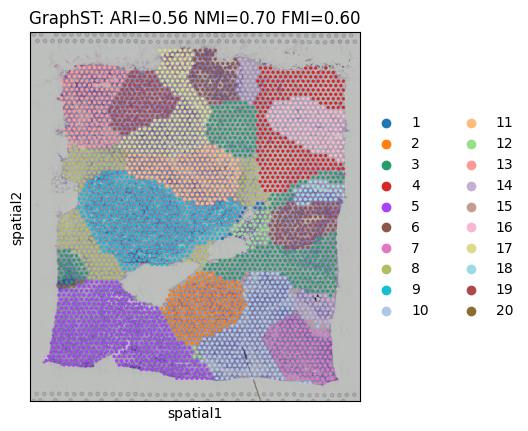

/data/changjiaxing/software/miniconda3/envs/scgdl_copy/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/changjiaxing/software/miniconda3/envs/scgdl_copy/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/changjiaxing/software/mini

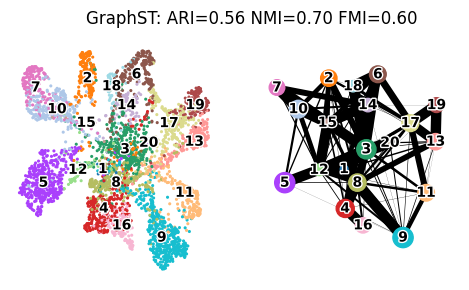

done!


In [10]:
datasets = ['HBC']
for i in range(len(datasets)):
    dataset = datasets[i]
    print(dataset)
    n_clusters = 20
    # read data
    file_fold = '../data/HBC/' + str(dataset) #please replace 'file_fold' with the download path
    adata = sc.read_visium(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique()
    # define model
    model = GraphST(adata, device=device)

    # train model
    adata = model.train()
    # set radius to specify the number of neighbors considered during refinement
    radius = 50

    tool = 'mclust' # mclust, leiden, and louvain

    # clustering
    # from GraphST.utils import clustering

    if tool == 'mclust':
        clustering(adata, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
    elif tool in ['leiden', 'louvain']:
        clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)
        # add ground_truth
    df_meta = pd.read_csv(file_fold + '/metadata.tsv', sep='\t')
    df_meta_layer = df_meta['ground_truth']
    adata.obs['ground_truth'] = df_meta_layer.values

    # filter out NA nodes
    adata = adata[~pd.isnull(adata.obs['ground_truth'])]

    # calculate metric ARI
    ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
    NMI = metrics.normalized_mutual_info_score(adata.obs['domain'], adata.obs['ground_truth'])
    FMI = metrics.fowlkes_mallows_score(adata.obs['domain'], adata.obs['ground_truth'])
    adata.uns['ARI'] = ARI
    adata.uns['NMI'] = NMI
    adata.uns['NMI'] = NMI

    print('Dataset:', dataset)
    print('ARI:', ARI)
    print('NMI:', NMI)
    print('NMI:', NMI)
    adata.write('./result_final/' +'final' + dataset +'.h5ad')
    title = 'GraphST: ARI={:.2f}'.format(ARI) +' NMI={:.2f}'.format(NMI) +' FMI={:.2f}'.format(FMI)
    sc.pl.spatial(adata, img_key="hires", color=['domain'], title=title, show=False)
    plt.savefig('./result_final/' + dataset + '_new.jpg', bbox_inches='tight', dpi=600)
    plt.show()
    #可视化umap
    sc.pp.neighbors(adata, use_rep='emb_pca')
    sc.tl.umap(adata)
    plt.rcParams["figure.figsize"] = (3, 3)
    sc.tl.paga(adata, groups='domain')
    sc.pl.paga_compare(adata, legend_fontsize=10, frameon=False, size=20, title=title, legend_fontoutline=2,show=False)
    plt.savefig('./result_final/' + dataset + '_umap_new.jpg', bbox_inches='tight', dpi=600)
    plt.show()
    print("done!")